This is the jupyter notebook that has been created by : Dimitris Gjergji (A.M: 1115201800029) and Konstantinos Lampropoulos (A.M: 1115201800092) for the lesson 'Data Mining Techniques' project.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
from collections import Counter
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


Pre-Processing

In [2]:
data = pd.read_csv('/content/drive/MyDrive/books_1.Best_Books_Ever.csv') #read the data
df = pd.DataFrame(data) #create the dataframe
df = df.dropna(subset=['description','language','genres','pages','publishDate','ratingsByStars'])  #drop the null values of the needed columns from the dataframe

df['ratingsByStars'] = df['ratingsByStars'].str.strip('[]') #remvove [] brackets
df['ratingsByStars'] = df['ratingsByStars'].str.replace("'",'') #remove the ' from each word
df[['ratingStar5','ratingStar4','ratingStar3','ratingStar2','ratingStar1']] = df['ratingsByStars'].str.split(',',expand=True) #split the string by each comma and add the new
#string to each of the new columns created

df['genres'] = df['genres'].str.strip('[]') #remove [] brackets
df['genreSingle'] = df['genres'].str.split(',').str[0].str.strip() #extract only the first string from the stri split method
df['Year'] = pd.to_datetime(df['publishDate'], errors='coerce') #conver the column to datetime object and if we encounter error set the value to null

df = df.loc[df['publishDate'].str.contains(r'\d'),:].copy() #records that have non-numeric value in publish date remove them from the dataframe

df['Year'] = df['Year'].dt.year #extract the year from the dates

Questions for extracting data (5 in total)

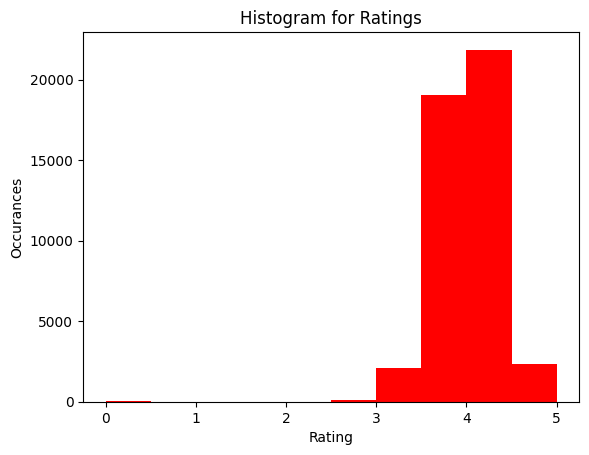

<ipython-input-3-33ab29290f70>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pages'] = df['pages'].astype(int)   #cast to sort the dataframe treating pages as integers and not strings


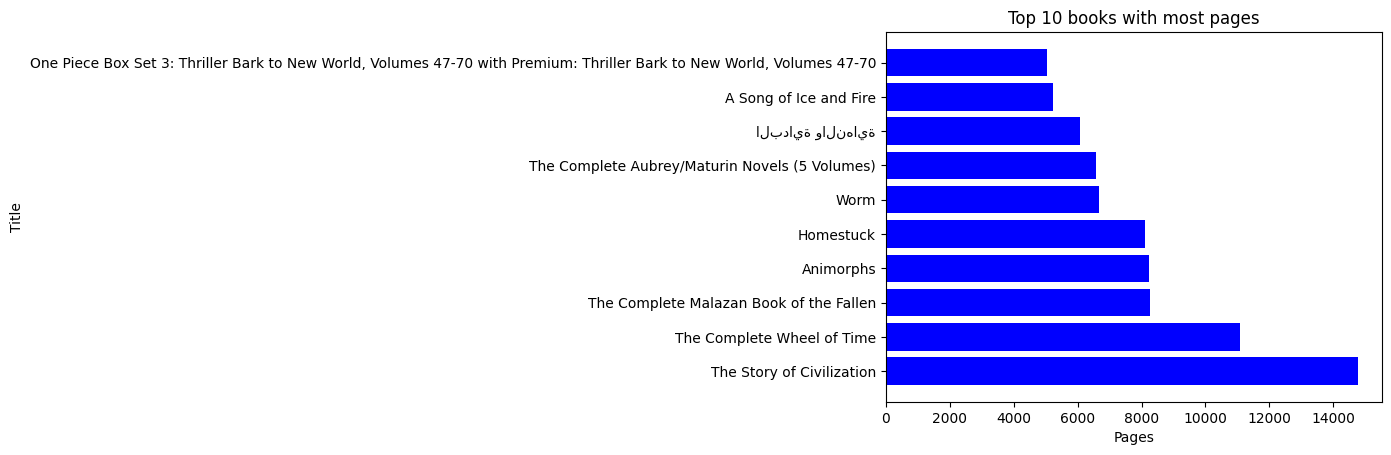

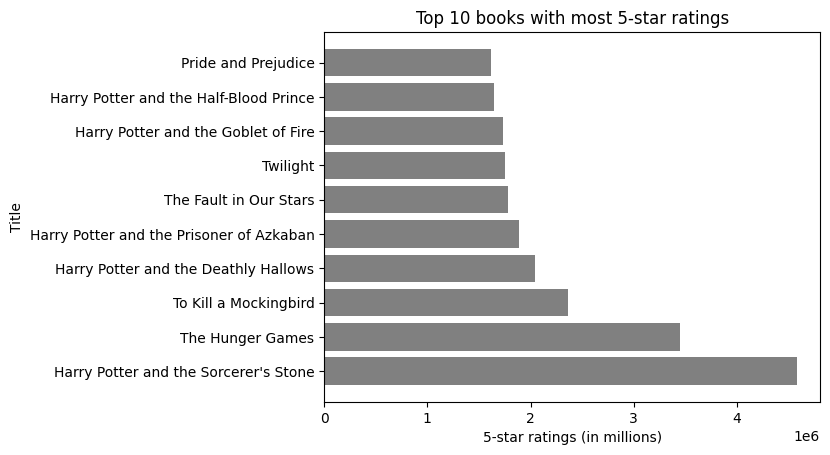

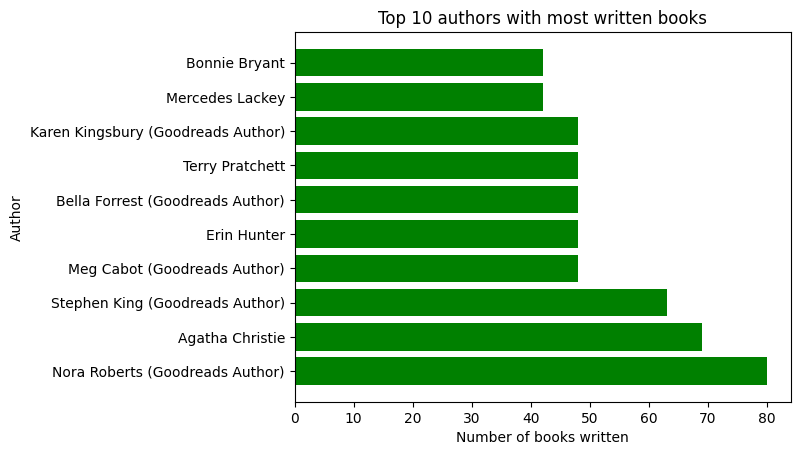

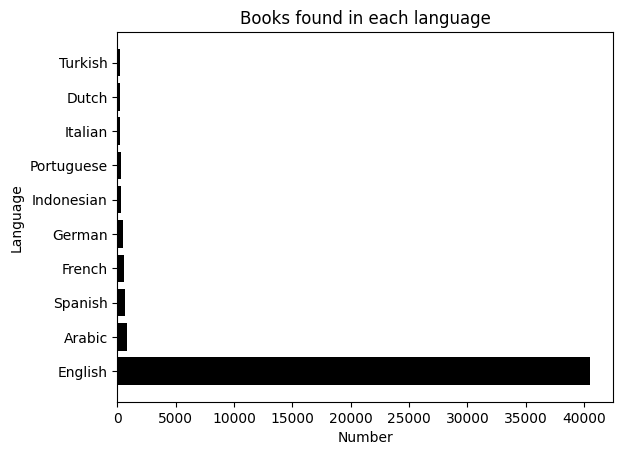

In [3]:
#1st graph (1.1 Question)
plt.hist(df['rating'],color='red')  #show the rating column of dataframe in a histogram
plt.title('Histogram for Ratings')
plt.xlabel('Rating')
plt.ylabel('Occurances')
plt.show()

#2nd graph (1.2 Question)
df['pages'] = df['pages'].astype(str) #in order to clean the page column that contains strings (18 cases found) first transform the object from int32(??) to str
df = df[df['pages'].str.isdigit()] # clean the dataframe for column page (drop non-numeric values)
df['pages'] = df['pages'].astype(int)   #cast to sort the dataframe treating pages as integers and not strings
dfSortedByPages = df.sort_values('pages', ascending=False,) #sort by descending order the dataframe by the pages column
df_top10 = dfSortedByPages.head(10)   #get only the top 10 cases
plt.barh(df_top10['title'], df_top10['pages'], color='blue') #create the bar-chart,on x-axis the number of pages and in y axis the title of the book

plt.xlabel('Pages') #add labels & title
plt.ylabel('Title')
plt.title('Top 10 books with most pages')
plt.show()

#3rd graph (1.3 Question)
df['ratingStar5'] = df['ratingStar5'].replace(r'^\s*$', 0, regex=True) #fill the whitespace values of column 'ratingStar5' with a zero digit so to be able to cast to int the column
df['ratingStar5'] = df['ratingStar5'].astype(int)   #cast to sort the dataframe treating 'ratingStar5' column as integers and not strings
dfNew = df[df['ratingStar5'] > 1000]  #get only the entries with 10.000 and above 5-star ratings first
dfSortedByPages = dfNew.sort_values('ratingStar5', ascending=False,) #sort by descending order the dataframe by the pages column
df_top10 = dfSortedByPages.head(10)   #get only the top 10 cases
plt.barh(df_top10['title'], df_top10['ratingStar5'], color='grey') #create the bar-chart,on x-axis the number of 5-star ratings and in y axis the title of the book


plt.xlabel('5-star ratings (in millions)') #add labels & title
plt.ylabel('Title')
plt.title('Top 10 books with most 5-star ratings')
plt.show()

#4rd graph (1.5 Question)
dfNew1 = df['author'].value_counts()  #distinct each author of the dataframe how many books has written
dfNew1 = dfNew1.head(10)   #get only the 10 top frequent authors of the dataframe
plt.barh(dfNew1.index,dfNew1.values, color='green')

plt.xlabel('Number of books written') #add labels & title
plt.ylabel('Author')
plt.title('Top 10 authors with most written books')
plt.show()

#5rd graph (1.8 Question)
dfNew2 = df['language'].value_counts()  #distinct each language of the dataframe how many books are written in each
dfNew2 = dfNew2.head(10)   #get only the 10 top most common languages of the dataframe
plt.barh(dfNew2.index,dfNew2.values, color='black')

plt.xlabel('Number') #add labels & title
plt.ylabel('Language')
plt.title('Books found in each language')
plt.show()

Recommendation system

In [4]:
NumberOfExaminedBooks = 1000  #Specifies the number of books that will print their most similar ones (1000 books ~ 14 min,100 books in 100 sec in google collab)
NumberOfRecommendedBooks = 100 #Specifies the number of recommended books that will print for each book

df = df[df['language'] == 'English'] #omit the books that are not written in English
vectorizerUni = TfidfVectorizer(ngram_range=(1,1), stop_words='english') #create a TfidfVectorizer object to extract unigrams without stopwords of english language
tfidfUni = vectorizerUni.fit_transform(df['description']) #transform text to numbers (fitting of vectorizer)
vectorizerBi = TfidfVectorizer(ngram_range=(2,2), stop_words='english') #create a TfidfVectorizer object to extract bigrams without stopwords of english language
tfidfBi = vectorizerBi.fit_transform(df['description']) #transform text to numbers (fitting of vectorizer)

def recommendUni(item_id, num):
      similar_rows = {}   #intializing the empty directory
      idx = df[df['bookId'] == item_id].index[0]     #find the index of the given Book Id in the dataframe to be able to get its similar books
      cos_sim = cosine_similarity(tfidfUni[idx],tfidfUni) #calculate the similarity of each row of a DataFrame and every other row
      similar_indices = cos_sim.argsort()[0][-num-1:-1][::-1] #sort the cosine similarity scores in ascending order and get last n values(since we need the most similar) omiting the first one that is itself
      print("Recommending ", num," books similar to: ", df.iloc[idx]['title'], "  (based on Unigrams)", 
            "\n-------------------------------------------------------------------------------------\n")
      for index in similar_indices:
            similar_rows[df.iloc[index]['title']] = [df.iloc[index]['description'], cos_sim[0][index]]    #store the n-similar books in a dictionary with the needing info
            print("Recommended: ", df.iloc[index]['title'],           #print it in the format that is needed the results
                  "\nDescription: ", df.iloc[index]['description'],
                  "\n( score:", cos_sim[0][index], ")\n\n")
            
def recommendBi(item_id, num):
      similar_rows = {}   #intializing the empty directory
      idx = df[df['bookId'] == item_id].index[0]     #find the index of the given Book Id in the dataframe to be able to get its similar books
      cos_sim = cosine_similarity(tfidfBi[idx],tfidfBi) #calculate the similarity of each row of a DataFrame and every other row
      similar_indices = cos_sim.argsort()[0][-num-1:-1][::-1] #sort the cosine similarity scores in ascending order and get last n values(since we need the most similar) omiting the first one that is itself
      print("Recommending ", num," books similar to: ", df.iloc[idx]['title'], "  (based on Bigrams)", 
            "\n-------------------------------------------------------------------------------------\n")
      for index in similar_indices:
            similar_rows[df.iloc[index]['title']] = [df.iloc[index]['description'], cos_sim[0][index]]    #store the n-similar books in a dictionary with the needing info
            print("Recommended: ", df.iloc[index]['title'],           #print it in the format that is needed the results
                  "\nDescription: ", df.iloc[index]['description'],
                  "\n( score:", cos_sim[0][index], ")\n\n")

for bookId in df['bookId'].head(NumberOfExaminedBooks):     #function that runs the recommendBooks function
      recommendUni(bookId,NumberOfRecommendedBooks)
      recommendBi(bookId,NumberOfRecommendedBooks)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
( score: 0.1475590482884887 )


Recommended:  Wil Deft 
Description:  "Come," said the cat. "It is time."  It shamed him, talking with animals.  "They summon you," she said. He guessed who his summoners must be.  "No," he said.  But imperial constables hunted him. He didn't know why. He fled upriver, terrified, into the great forest, where ancient spells lingered, his only guides this cold-eyed cat and feckless dog. And with every decision, every act, he was changed.  He'd never chosen this--they'd bred him for it.  He must be a thief. 
( score: 0.147435273172584 )


Recommended:  The Autobiography of Foudini M. Cat 
Description:  Grace the Cat is not at all like me, as she is forever bent on mischief. But because I am an older and wiser cat, she looks to me for counsel, and so I have allowed Grace to prevail upon me to set down the story of my life as a housecat in the human world. . . .As the irrepressible Foudini M. Cat regales 

Classification

In [5]:
common_words = Counter(df['genreSingle']) #count how many books correspond to each genre

most_common = common_words.most_common(10) #keep the 10 most common

most_common_genres = [] #the most common method returns a tuple containing the genre name and
for word,count in most_common: #the number of the occurences for each genre in the dataframe
    most_common_genres.append(word) #so we split the tuple and keep only the genre name

new_df = df.copy() #create a copy of the dataframe
new_df = new_df.head(20000) #keep the first 20000 rows for classification
new_df = new_df[new_df['genreSingle'].apply(lambda x: any(word in x for word in most_common_genres))]
#apply a lamdba function to keep only the books that are in the 10 most common genres

columns_keep = ['genreSingle','description','bookId'] #we want to keep only these 3 columns
new_df = new_df.drop(columns=[col for col in new_df.columns if col not in columns_keep]) #delete the columns which are not in the list above

new_df['description'] = new_df['description'].str.lower() #make all words lower case
stop  = stopwords.words('english') #initialize stop words to english language
pat = r'\b(?:{})\b'.format('|'.join(stop)) #regex expression
new_df['description'] = new_df['description'].str.replace(pat,'',regex=True) #apply regex expr
new_df['description'] = new_df['description'].str.replace(r'\s+',' ',regex=True)
cleaned = []
elements = list(new_df['description']) 
for i in elements : #iterate over all elements in the description column
    FilteredText = re.sub('https?://[A-Za-z0-9./]+','',i) #clean also the links from each element of the column
    FilteredText = re.sub("[^a-zA-Z0-9]", " ",FilteredText) #clean also punctuation
    cleaned.append(re.sub(r'^RT[\s]+', '', FilteredText))
new_df['description'] = cleaned
new_df['description'] = new_df['description'].apply(lambda x: x.split()) #split the text in a list of lists
model = Word2Vec(new_df['description'],vector_size=200,window=5,min_count=2,sg=1,hs=0,negative=10,workers=4,seed=34) #initialize word2vec model
model.train(new_df['description'],total_examples=len(new_df),epochs=20) #train it

(32377535, 33483900)

Save Files

In [6]:
with open('W2V.pkl' ,"wb") as file: #open it
    pickle.dump(model,file) #save the model
with open('df.pkl' ,"wb") as file: #open it
    pickle.dump(new_df,file) #save the model

Open Files

In [7]:
with open('df.pkl',"rb") as file:
    new_df = pickle.load(file) #open dataframe
with open('W2V.pkl',"rb") as file:
    model = pickle.load(file) #open dataframe

Word Embeddings for classification

In [8]:
word_emdeddings = []
for sentence in new_df['description']: #iterate the description column
    vectors = [model.wv[word] for word in sentence if word in model.wv] #for each word in each row of the description column
    if vectors: #check if the word exists in the vocabulary and get the vectors for each word
        mean = np.mean(vectors, axis=0) #calculate the mean of the vectors
    else:
        np.zeros(model.vector_size) #add an array of 200 with elements of 0
    word_emdeddings.append(mean) #append the vector the the list

Train Test Splitting

In [9]:
X = np.array(word_emdeddings) #create an array of the list
y = new_df['genreSingle'] #split data to train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42) #split to train and testset

Naive Bayes

In [10]:
clf = GaussianNB() #Naive Bayes method to classify

scoring = { #Create a Dictionary to store the scoring methods
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall': make_scorer(recall_score, average='weighted', zero_division=1),
    'f_measure': make_scorer(f1_score, average='weighted', zero_division=1),
    'accuracy': make_scorer(accuracy_score)
}
warnings.filterwarnings('ignore',category=UserWarning) #ignore the warning that df['description] is 1 column
scores = cross_validate(clf, X, y, cv=10, scoring=scoring) #perfrom 10 fold cross validation and return the results for the scoring methods specified above
print("Precision:", scores['test_precision'].mean()) #print the average precision from the 10 tests
print("Recall:", scores['test_recall'].mean()) #prin the average recall from the 10 tests
print("F-measure:", scores['test_f_measure'].mean()) #print the average f measure from the 10 tests
print("Accuracy:", scores['test_accuracy'].mean()) #print the average accuracy from the 10 tests



Precision: 0.43575549988748846
Recall: 0.33104999999999996
F-measure: 0.3443835339986225
Accuracy: 0.33104999999999996


Support Vector Machines

In [11]:
svm = SVC(kernel='rbf',C=10.0,gamma='scale')
scoring = { #Create a Dictionary to store the scoring methods
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall': make_scorer(recall_score, average='weighted', zero_division=1),
    'f_measure': make_scorer(f1_score, average='weighted', zero_division=1),
    'accuracy': make_scorer(accuracy_score)
}
scores = cross_validate(svm, X, y, cv=10, scoring=scoring) #perfrom 10 fold cross validation and return the results for the scoring methods specified above
print("Precision:", scores['test_precision'].mean()) #print the average precision from the 10 tests
print("Recall:", scores['test_recall'].mean()) #prin the average recall from the 10 tests
print("F-measure:", scores['test_f_measure'].mean()) #print the average f measure from the 10 tests
print("Accuracy:", scores['test_accuracy'].mean()) #print the average accuracy from the 10 tests

Precision: 0.5418419798137792
Recall: 0.5258499999999999
F-measure: 0.5004992869634971
Accuracy: 0.5258499999999999


$
\begin{array}{|c|c|c|c|c|}
\hline
\text{Kernel} & \text{C} & \text{Gamma} & \text{Accuracy} & \text{Time}\\
\hline
\text{rbf} & \text{1.0} & \text{scale} & \text{49.02\%} & \text{1.50m}\\
\hline
\text{rbf} & \text{10.0} & \text{scale} & \text{52.34\%} & \text{1.48m}\\
\hline
\text{rbf} & \text{100.0} & \text{scale} & \text{49.02\%} & \text{1.49m}\\
\hline
\text{rbf} & \text{10.0} & \text{auto} & \text{43.10\%} & \text{1.54m}\\
\hline
\text{linear} & \text{10.0} & \text{scale} & \text{49.27\%} & \text{1.33m}\\
\hline
\text{linear} & \text{10.0} & \text{auto} & \text{49.27\%} & \text{1.33m}\\
\hline
\text{rbf} & \text{10.0} & \text{scale} & \text{53.28\%} & \text{2.46m}\\
\hline
\end{array}
$
$$ $$
Στο τελευταίο πείραμα εφαρμόστηκαν οι βέλτιστες παράμμετροι (που υπολογίστηκαν πάνω στο 60% του train set) σε όλο το train set.Επίσης το 10 fold cross validation εφαρμόστηκε σε όλο το database.

Random Forest

In [12]:
random_forest = RandomForestClassifier(n_jobs=-1,n_estimators=200,max_depth=64,max_leaf_nodes=9000,min_samples_split=2,criterion='gini',bootstrap=False)
scoring = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall': make_scorer(recall_score, average='weighted', zero_division=1),
    'f_measure': make_scorer(f1_score, average='weighted', zero_division=1),
    'accuracy': make_scorer(accuracy_score)
}
scores = cross_validate(random_forest, X, y, cv=10, scoring=scoring)#perfrom 10 fold cross validation and return the results for the scoring methods specified above
print("Precision:", scores['test_precision'].mean()) #print the average precision from the 10 tests
print("Recall:", scores['test_recall'].mean()) #prin the average recall from the 10 tests
print("F-measure:", scores['test_f_measure'].mean()) #print the average f measure from the 10 tests
print("Accuracy:", scores['test_accuracy'].mean()) #print the average accuracy from the 10 tests

Precision: 0.5763043653611806
Recall: 0.41345
F-measure: 0.3332733319391993
Accuracy: 0.41345


$
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
\text{Estimators} & \text{Tree Depth} & \text{Max Leaf Nodes} & \text{Min Samples Split} & \text{Split Critera} & \text{Boostrap} & \text{Accuracy} &
\text{Time}\\
\hline
\text{150} & \text{64} & \text{11000} & \text{2} & \text{Gini} & \text{True} & \text{38.93\%} &
\text{11s}\\
\hline
\text{150} & \text{64} & \text{10000} & \text{2} & \text{Gini} & \text{True} & \text{38.88\%} &
\text{11s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{2} & \text{Gini} & \text{True} & \text{39.33\%} &
\text{11s}\\
\hline
\text{150} & \text{16} & \text{9000} & \text{2} & \text{Gini} & \text{True} & \text{38.65\%} &
\text{10.4s}\\
\hline
\text{150} & \text{32} & \text{9000} & \text{2} & \text{Gini} & \text{True} & \text{38.76\%} &
\text{11.3s}\\
\hline
\text{150} & \text{128} & \text{9000} & \text{2} & \text{Gini} & \text{True} & \text{38.93\%} &
\text{11.3s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{0.5} & \text{Gini} & \text{True} & \text{19.51\%} &
\text{11s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{10} & \text{Gini} & \text{True} & \text{38.87\%} &
\text{11s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{25} & \text{Gini} & \text{True} & \text{37.63\%} &
\text{11s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{25} & \text{Gini} & \text{True} & \text{38.45\%} &
\text{11.4s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{2} & \text{Entropy} & \text{True} & \text{38.35\%} &
\text{42.6s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{2} & \text{Log Loss} & \text{True} & \text{38.55\%} &
\text{42.7s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{2} & \text{Gini} & \text{False} & \text{40.14\%} &
\text{12.7s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{2} & \text{Entropy} & \text{False} & \text{39.56\%} &
\text{1m14.8s}\\
\hline
\text{150} & \text{64} & \text{9000} & \text{2} & \text{Log Loss} & \text{False} & \text{39.77\%} &
\text{42.7s}\\
\hline
\text{200} & \text{64} & \text{9000} & \text{2} & \text{Gini} & \text{False} & \text{40.66\%} &
\text{16s}\\
\hline
\text{250} & \text{64} & \text{9000} & \text{2} & \text{Gini} & \text{False} & \text{40.28\%} &
\text{27s}\\
\hline
\text{250} & \text{64} & \text{9000} & \text{2} & \text{Entropy} & \text{False} & \text{40.00\%} &
\text{2m.6s}\\
\hline
\text{200} & \text{64} & \text{9000} & \text{2} & \text{Gini} & \text{False} & \text{40.84\%} &
\text{30s}\\
\hline
\end{array}
$
$$ $$
Το τελευταίο πείραμα εφαρμόστηκε πάνω σε όλο το Train Set,ενώ τα υπόλοιπα στο 60% του.